In [ ]:
!pip install torch torchvision
!pip install timm
!pip install transformers
!pip install datasets
!pip install diffusers
!pip install accelerate
!pip install opencv-python
#!pip install pillow


In [ ]:
import torch

torch.cuda.is_available()


torch.cuda.device_count()


torch.cuda.current_device()

torch.cuda.device(0)

torch.cuda.get_device_name(0)

'NVIDIA GeForce RTX 3050 Laptop GPU'

In [ ]:
torch.cuda.get_device_name(0)

'NVIDIA GeForce RTX 3050 Laptop GPU'

### Imports

In [ ]:
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

import timm
from transformers import AutoFeatureExtractor

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import cv2
from datasets import load_dataset

from diffusers import StableDiffusionPipeline
import random


c:\Users\arhar\.conda\envs\pytorch\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Part 1: **Spoof Detection with Vision Transformer (ViT)**


In [ ]:
dataset = load_dataset('nguyenkhoa/celeba-spoof-for-face-antispoofing-test')

In [ ]:
dataset

DatasetDict({
    test: Dataset({
        features: ['cropped_image', 'labels', 'labelNames'],
        num_rows: 67170
    })
})

In [ ]:
full_dataset = dataset['test'] #full dataset only one split
print("Total samples:", len(full_dataset))

# Split into a 20% training and 80% testing subset
split_dataset = full_dataset.train_test_split(test_size=0.2, seed=42)
train_dataset = split_dataset['train']
test_dataset = split_dataset['test']

print('Training samples:', len(train_dataset))
print('Testing samples:', len(test_dataset))


def small_subset(dataset, fraction=0.2):
    num_samples = int(len(dataset) * fraction)
    return dataset.select(range(num_samples))

train_small = small_subset(train_dataset)
test_small = small_subset(test_dataset)
print('Reduced training samples:', len(train_small))
print('Reduced testing  samples:', len(test_small))

Total samples: 67170
Training samples: 53736
Testing samples: 13434
Reduced training samples: 10747
Reduced testing  samples: 2686


In [ ]:
# Save the dataset
train_small.save_to_disk("./train_small_dataset")
test_small.save_to_disk("./test_small_dataset")


Saving the dataset (1/1 shards): 100%|██████████| 2686/2686 [00:00<00:00, 3037.74 examples/s]


In [ ]:
from datasets import load_from_disk

train_small = load_from_disk("./train_small_dataset")
test_small = load_from_disk("./test_small_dataset")


### FeatureExtractor

In [ ]:
feature_extractor = AutoFeatureExtractor.from_pretrained('google/vit-base-patch16-224')
model_name = 'vit_base_patch16_224'  # From timm

# Initialize Timm model for binary classification.
vit_model = timm.create_model(model_name, pretrained=True, num_classes=2)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
vit_model.to(device)

# Simple transformations function
def preprocess_image(example):
    img = example["cropped_image"]
    if img is None:
        img = Image.new("RGB", (224, 224))
    else:
        img = img.convert("RGB")

    inputs = feature_extractor(img, return_tensors="pt")
    example["image_tensor"] = inputs["pixel_values"][0]

    example["labels"] = example["labels"]
    return example



c:\Users\arhar\.conda\envs\pytorch\Lib\site-packages\huggingface_hub\file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
c:\Users\arhar\.conda\envs\pytorch\Lib\site-packages\transformers\models\vit\feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [ ]:
train_transformed = train_small.map(preprocess_image)
test_transformed = test_small.map(preprocess_image)

Map: 100%|██████████| 2686/2686 [01:56<00:00, 23.10 examples/s] 


In [ ]:
def collate_fn(batch):
    pixel_values = torch.stack([
        torch.tensor(b["image_tensor"])  # convert from list -> tensor
        for b in batch
    ])
    labels = torch.tensor([b["labels"] for b in batch], dtype=torch.long)
    return pixel_values, labels






train_loader = DataLoader(train_transformed, batch_size=8, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_transformed, batch_size=8, shuffle=False, collate_fn=collate_fn)

print("Train Loader length:", len(train_loader))
print("Test Loader length: ", len(test_loader))

Train Loader length: 1344
Test Loader length:  336


In [ ]:
# Save the transformed datasets
train_transformed.save_to_disk('train_transformed')
test_transformed.save_to_disk('test_transformed')

Saving the dataset (4/4 shards): 100%|██████████| 2686/2686 [00:15<00:00, 168.08 examples/s]


In [ ]:
from datasets import load_from_disk
train_transformed = load_from_disk('train_transformed')
test_transformed = load_from_disk('test_transformed')

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(vit_model.parameters(), lr=1e-4)

num_epochs = 1  # > 2 takes alot of time

vit_model.train()
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, (pixel_values, labels) in enumerate(train_loader):
        pixel_values = pixel_values.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = vit_model(pixel_values)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

Epoch [1/1], Loss: 0.3223


In [ ]:
checkpoint = {
    "epoch": num_epochs,
    "model_state_dict": vit_model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),

}
torch.save(checkpoint, "vit_checkpoint.pth")
print("Full checkpoint saved to vit_checkpoint.pth")

Full checkpoint saved to vit_checkpoint.pth


In [ ]:
checkpoint = torch.load("vit_checkpoint.pth")
vit_model.load_state_dict(checkpoint["model_state_dict"])


<All keys matched successfully>

### Evaluation

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

vit_model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for pixel_values, labels in test_loader:
        pixel_values = pixel_values.to(device)
        labels = labels.to(device)

        outputs = vit_model(pixel_values)
        preds = torch.argmax(outputs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

acc = accuracy_score(all_labels, all_preds)
prec = precision_score(all_labels, all_preds, average='binary')
rec = recall_score(all_labels, all_preds, average='binary')
f1 = f1_score(all_labels, all_preds, average='binary')

print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 Score:  {f1:.4f}")

Accuracy:  0.8779
Precision: 0.8541
Recall:    0.9979
F1 Score:  0.9204


In [ ]:
img = Image.open('trump_reall.jpeg').convert('RGB')
inputs = feature_extractor(img, return_tensors='pt')
inputs = inputs['pixel_values'].to(device)
outputs = vit_model(inputs)
pred = torch.argmax(outputs, dim=1)
print('Prediction:', pred.item()) # 0 for real, 1 for spoof

#gives wrong label

Prediction: 1


In [ ]:
img = Image.open('trump_fake.jpg').convert('RGB')
inputs = feature_extractor(img, return_tensors='pt')
inputs = inputs['pixel_values'].to(device)
outputs = vit_model(inputs)
pred = torch.argmax(outputs, dim=1)
print('Prediction:', pred.item()) # 0 for real, 1 for spoof

Prediction: 1


# Part 2: AI-Powered Visual Search with CLIP

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

VAL2017_FOLDER = "val2017"
ANNOTATIONS_FOLDER = "annotations"
CAPTIONS_FILE = os.path.join(ANNOTATIONS_FOLDER, "captions_val2017.json")

Using device: cuda


In [ ]:
clip_model_id = "openai/clip-vit-base-patch32"
clip_model = CLIPModel.from_pretrained(clip_model_id).to(device)
clip_processor = CLIPProcessor.from_pretrained(clip_model_id)
clip_model.eval()

@torch.no_grad()
def get_image_embedding(pil_img: Image.Image):
    """Compute normalized CLIP image embedding"""
    inputs = clip_processor(images=pil_img, return_tensors="pt").to(device)
    img_emb = clip_model.get_image_features(**inputs)
    return img_emb / img_emb.norm(p=2, dim=-1, keepdim=True)

@torch.no_grad()
def get_text_embedding(text: str):
    """Compute normalized CLIP text embedding """
    inputs = clip_processor(text=[text], return_tensors="pt").to(device)
    txt_emb = clip_model.get_text_features(**inputs)
    return txt_emb / txt_emb.norm(p=2, dim=-1, keepdim=True)

In [ ]:
all_image_files = [
    f for f in os.listdir(VAL2017_FOLDER) if f.lower().endswith(".jpg")
]
print(f"Found {len(all_image_files)} images in {VAL2017_FOLDER}.")

filename_to_emb = {}
filename_to_image = {}
for i, filename in enumerate(all_image_files):
    path = os.path.join(VAL2017_FOLDER, filename)
    try:
        pil_img = Image.open(path).convert("RGB")
        emb = get_image_embedding(pil_img)
        filename_to_emb[filename] = emb
        filename_to_image[filename] = pil_img
    except Exception as e:
        print(f"Error reading {path}: {e}")

print(f"Embedded {len(filename_to_emb)} images successfully.")

Found 5000 images in val2017.
Embedded 5000 images successfully.


In [ ]:
import json

with open(CAPTIONS_FILE, "r", encoding="utf-8") as f:
    coco_captions = json.load(f)

image_id_to_filename = {}
image_id_to_captions = {}

for img_info in coco_captions["images"]:
    image_id = img_info["id"]
    file_name = img_info["file_name"]
    image_id_to_filename[image_id] = file_name


for ann in coco_captions["annotations"]: # Build mapping for annotations: each annotation
    img_id = ann["image_id"]
    caption = ann["caption"]
    if img_id not in image_id_to_captions:
        image_id_to_captions[img_id] = []
    image_id_to_captions[img_id].append(caption)


filename_to_image_id = {} # Build reverse mapping: filename -> image_id
for image_id, filename in image_id_to_filename.items():
    filename_to_image_id[filename] = image_id



In [ ]:
def retrieve_top_k_images(query: str, k=5):
    """
    Text query and image embedding comparison
    """
    query_emb = get_text_embedding(query)
    sims = []
    for filename, img_emb in filename_to_emb.items():
        # For normalized embeddings, cosine similarity = dot product.
        sim = torch.matmul(query_emb, img_emb.T).item()
        sims.append((sim, filename))
    sims.sort(key=lambda x: x[0], reverse=True)
    return sims[:k]

def compare_query_to_captions(query: str, captions_list):

    query_emb = get_text_embedding(query)
    best_sim = -1.0
    best_caption = ""
    for caption in captions_list:
        caption_emb = get_text_embedding(caption)
        sim = torch.matmul(query_emb, caption_emb.T).item()
        if sim > best_sim:
            best_sim = sim
            best_caption = caption
    return best_sim, best_caption

In [ ]:
def display_retrieval_with_caption_comparison(query: str, k=5):
    top_results = retrieve_top_k_images(query, k)
    print(f"\nUser Query: '{query}'")
    for sim, filename in top_results:
        # Retrieve the image's official captions via image_id.
        image_id = filename_to_image_id.get(filename)
        if image_id and image_id in image_id_to_captions:
            captions_list = image_id_to_captions[image_id]
            caption_sim, best_caption = compare_query_to_captions(query, captions_list)
        else:
            caption_sim, best_caption = 0.0, "No caption available"
        print(f"Image: {filename} | Image sim: {sim:.4f} | Caption sim: {caption_sim:.4f}")
        plt.figure()
        plt.imshow(filename_to_image[filename])
        plt.title(f"Image sim: {sim:.4f}\n Caption: {best_caption}\nCaption sim: {caption_sim:.4f}")
        plt.axis("off")
        plt.show()


User Query: 'a cat in a house'
Image: 000000491216.jpg | Image sim: 0.3001 | Caption sim: 0.8435


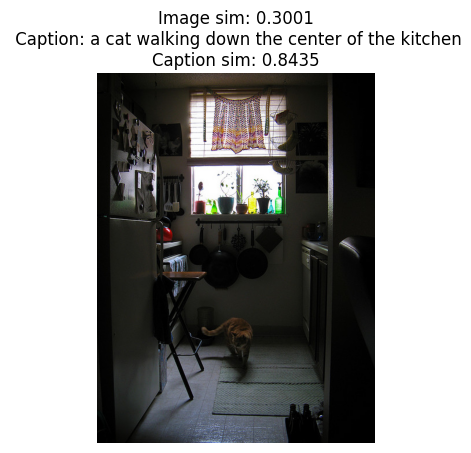

Image: 000000360943.jpg | Image sim: 0.2969 | Caption sim: 0.6296


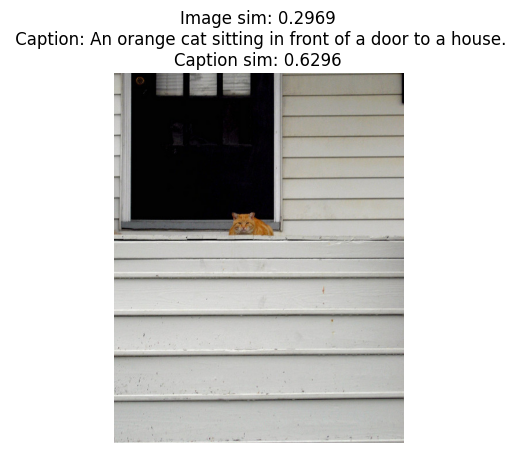

Image: 000000568690.jpg | Image sim: 0.2905 | Caption sim: 0.7451


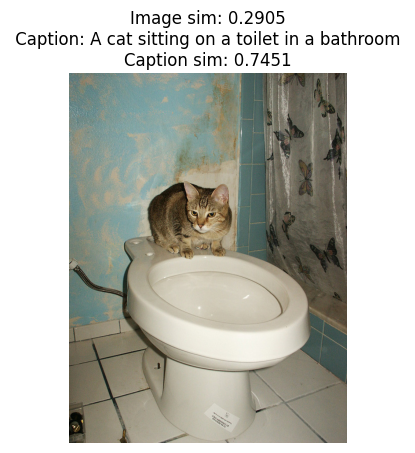

Image: 000000243344.jpg | Image sim: 0.2853 | Caption sim: 0.7620


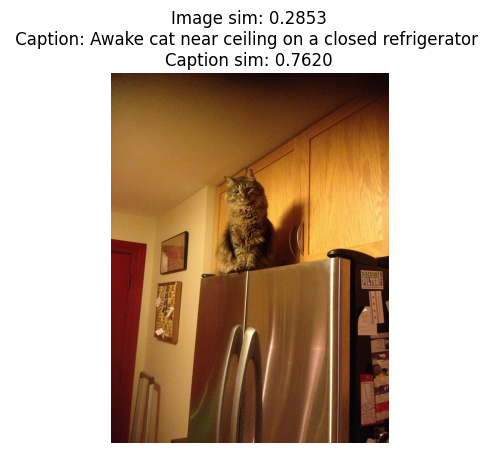

Image: 000000014007.jpg | Image sim: 0.2851 | Caption sim: 0.6764


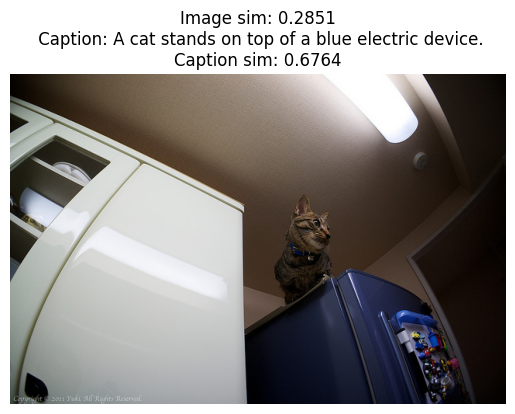

In [ ]:
user_query = "a cat in a house"
display_retrieval_with_caption_comparison(user_query, k=5)

# Part 3: Stable Diffusion

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

Using device: cuda


In [ ]:
model_id = "runwayml/stable-diffusion-v1-5"
pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16)
pipe = pipe.to(device)
pipe.safety_checker = lambda images, **kwargs: (images, False)

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]c:\Users\arhar\.conda\envs\pytorch\Lib\site-packages\huggingface_hub\file_download.py:142: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\arhar\.cache\huggingface\hub\models--runwayml--stable-diffusion-v1-5. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Loading pipeline components...: 100%|█████████

In [ ]:
save_path = "./my_saved_stable_diffusion"
pipe.save_pretrained(save_path)

print(f"Model saved to {save_path}")

In [ ]:
from diffusers import StableDiffusionPipeline
pipe = StableDiffusionPipeline.from_pretrained("./my_saved_stable_diffusion", torch_dtype=torch.float16)
pipe = pipe.to(device)

Loading pipeline components...: 100%|██████████| 6/6 [00:00<00:00, 12.22it/s]
You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


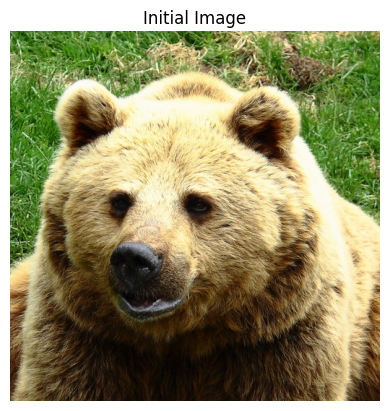

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

# Path to dataset
init_image_path = "val2017/000000000285.jpg"

init_image = Image.open(init_image_path).convert("RGB")
init_image = init_image.resize((512, 512))

plt.figure()
plt.title("Initial Image")
plt.imshow(init_image)
plt.axis("off")
plt.show()

In [ ]:
pipe.safety_checker = lambda images, **kwargs: (images, [False] * len(images)) #need to change for one image only

In [ ]:
def image_to_image(prompt):

    strength = 0.1  # low value to keep image slightly changed
    guidance_scale = 7.5
    num_inference_steps = 50

    # Generate the new image using the image-to-image pipeline
    result = pipe(prompt=prompt, init_image=init_image, strength=strength,
                guidance_scale=guidance_scale, num_inference_steps=num_inference_steps)

    output_image = result.images[0]


    plt.figure()
    plt.title("Image-to-Image Generation")
    plt.imshow(output_image)
    plt.axis("off")
    plt.show()

100%|██████████| 50/50 [00:10<00:00,  4.63it/s]


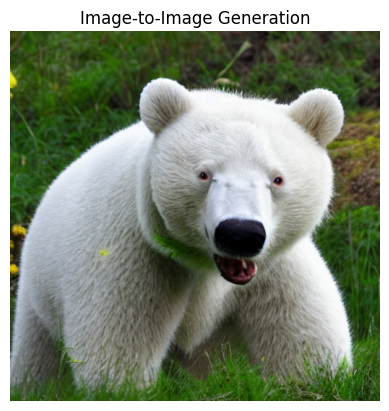

In [ ]:
image_to_image(prompt = "white bear")

100%|██████████| 50/50 [00:10<00:00,  4.67it/s]


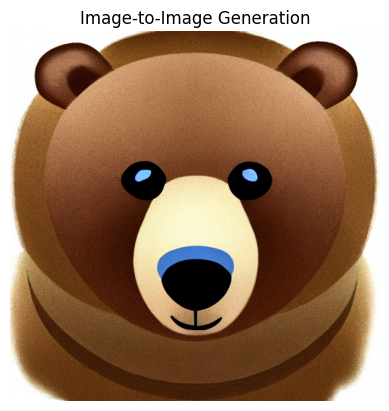

In [ ]:
image_to_image(prompt = "animated bear")

100%|██████████| 50/50 [00:10<00:00,  4.67it/s]


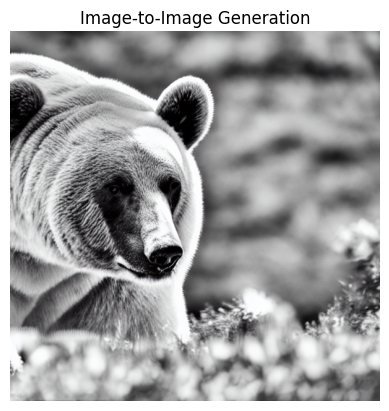

In [ ]:
image_to_image(prompt = "black and white bear")

In [ ]:
def generate_image(prompt, guidance_scale=7.5, num_inference_steps=50, strength=None, init_image=None): #generate image from prompt only

    if init_image is not None and strength is not None:
        result = pipe(prompt=prompt, init_image=init_image, strength=strength,
                      guidance_scale=guidance_scale, num_inference_steps=num_inference_steps)
    else:
        result = pipe(prompt=prompt, guidance_scale=guidance_scale, num_inference_steps=num_inference_steps)
    return result.images[0]

In [ ]:
prompt_variation = "A picture of the President smiling in Different Countries "

# Variation 2:
img_var1 = generate_image(
    prompt_variation,
    guidance_scale=7.5,
    num_inference_steps=30
)

# Variation 2:
img_var2 = generate_image(
    prompt_variation,
    guidance_scale=12.0,
    num_inference_steps=30
)

# Variation 3:
img_var3 = generate_image(
    prompt_variation,
    guidance_scale=7.5,
    num_inference_steps=50
)

# Variation 4:
img_var4 = generate_image(
    prompt_variation,
    init_image=init_image,
    strength=0.7,  #dont need strength because it is not image-to-image but did it for experiments sake
    guidance_scale=7.5,
    num_inference_steps=50
)



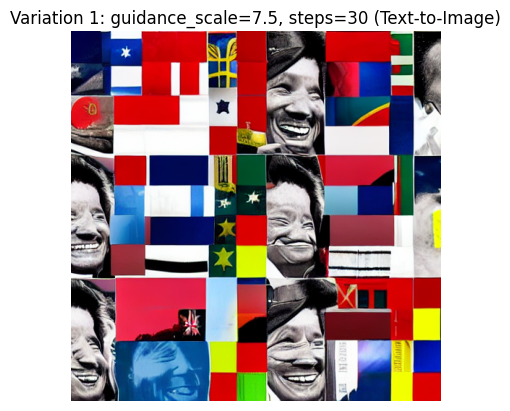

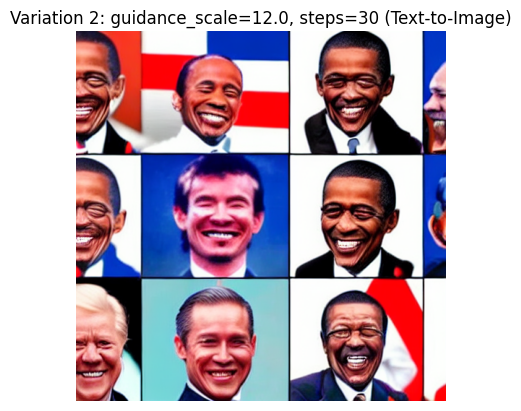

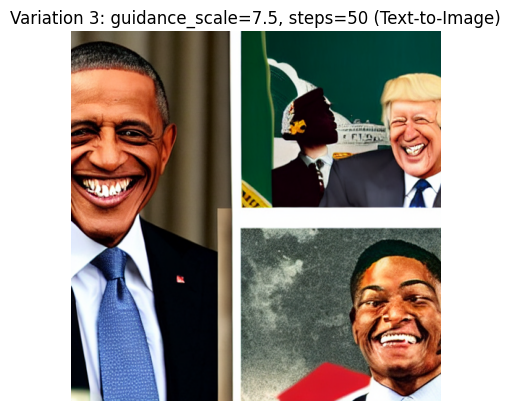

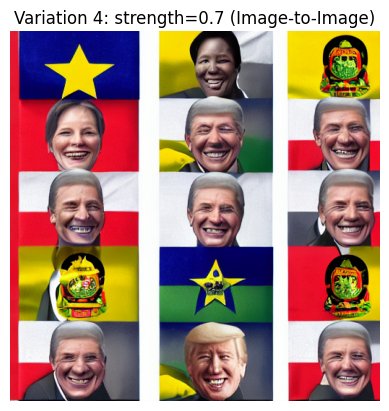

In [ ]:
variations = [
    ("Variation 1: guidance_scale=7.5, steps=30 (Text-to-Image)", img_var1),
    ("Variation 2: guidance_scale=12.0, steps=30 (Text-to-Image)", img_var2),
    ("Variation 3: guidance_scale=7.5, steps=50 (Text-to-Image)", img_var3),
    ("Variation 4: strength=0.7 (Image-to-Image)", img_var4)
]

for title, image in variations:
    plt.figure()
    plt.title(title)
    plt.imshow(image)
    plt.axis("off")
    plt.show()

100%|██████████| 50/50 [00:10<00:00,  4.60it/s]


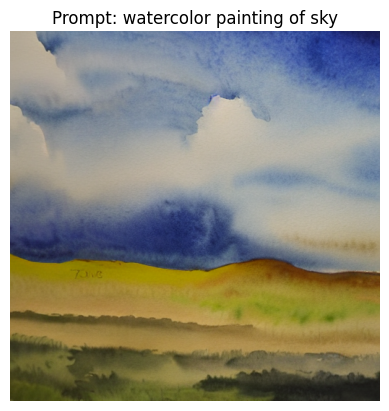

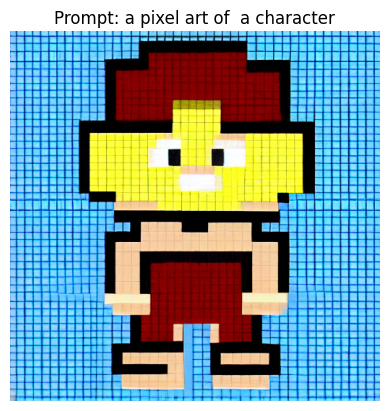

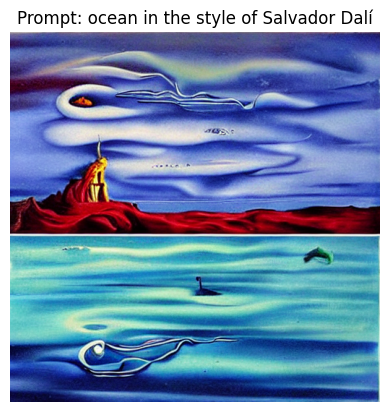

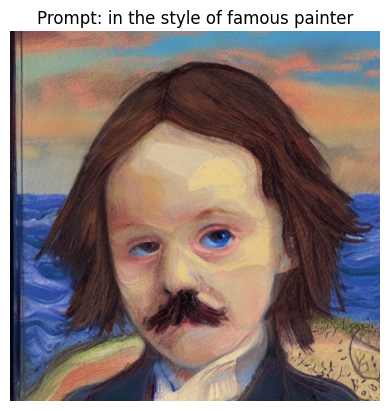

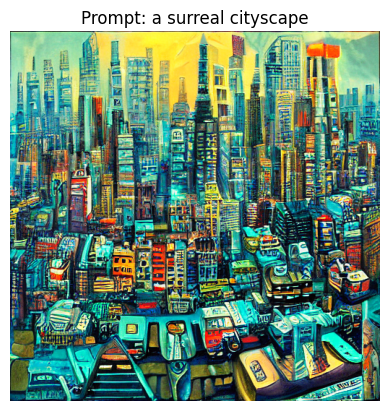

In [ ]:
prompts = [
    "watercolor painting of sky",
    "a pixel art of  a character",
    "ocean in the style of Salvador Dalí",
    "in the style of famous painter",
    "a surreal cityscape"
]

# Using the same parameters for all prompts:
consistent_guidance_scale = 7.5
consistent_steps = 50

generated_images = {}
for p in prompts:
    generated_images[p] = generate_image(p, guidance_scale=consistent_guidance_scale, num_inference_steps=consistent_steps)

# Display results for different prompts
for p, img in generated_images.items():
    plt.figure()
    plt.title(f"Prompt: {p}")
    plt.imshow(img)
    plt.axis("off")
    plt.show()
